In [68]:
import numpy as np
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import cdist
from math import ceil
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [69]:
# Очистка слов паразитов

def cleaner(text_):
    bad_words_1 = ['все', 'для', 'его', 'ему', 'или', 'так', 'что', 'чем', 'эти', 'быть',\
                   'если', 'есть', 'всех', 'про', 'при', 'того', 'либо', 'без', \
                   'был', 'вам', 'вас', 'ваш', 'вкр', 'вот', 'всю', 'вся', 'где',\
                   'для', 'дня', 'еще', 'зао', 'или', 'имя', 'ищу', 'как', 'ком', 'кто', \
                   'меж', 'мне', 'мог', 'мод', 'мои', 'мой', 'моя', \
                   'над', 'нам', 'нас', 'наш', 'нее', 'ней', 'нем', 'нео', 'нет', 'ним',\
                   'них', 'она', 'они', 'опа', 'под', 'пол', 'пор', 'при', 'рад',\
                   'сам', 'сей', 'там', 'тем', 'тип', 'тож', 'той', 'тот', 'тур', 'тут', 'удэ', 'уже',\
                   'эта', 'это', 'эту', 'буде', 'будь',\
                   'была', 'были', 'было', 'вами', 'изза', 'меня', 'либо',\
                   'мной', 'моих', 'либо','надо', 'нами', 'наша', 'наше',\
                   'наши', 'нашу', 'него', 'нету', 'ниже', 'ними',\
                   'ныне', 'раза', 'разы','сама', 'сами', 'свое', 'свои',\
                   'свой', 'свою', 'своя', 'себе', 'себя', 'типо',\
                   'таки', 'тебе', 'туда','хоть', 'хотя','чуть', 'чтобы',\
                   'этак','этим', 'этих', 'этой', 'этом', 'этот', 'ведь',\
                   'даже', 'имея', 'иную', 'себя', 'этого'
                  ]
    
    for i in bad_words_1:
        text_ = text_.replace(' ' + i + ' ', ' ')
        
    return text_

In [75]:
# Текст тегов h1, h2, h3 без коротких слов цифр и прочего мусора

def get_headings(soup):
    words_ = str()
    
    for title in soup.find_all(['h1', 'h2', 'h3']):
        words_ += (title.text + ' ')
        
    cleaner(words_)
    words_ = re.sub(r'\W', ' ', words_)
    words_ = re.sub(r'\d', ' ', words_)
    words_ = re.sub(r'\b\w{0,2}\b', ' ', words_)
    words_ = re.sub('\s+', ' ', words_)
    # Надо ли чистить? Надо ли только уникальные
    return words_

In [71]:
#Список имеет следующий вид: list = [text_1, text2, ... , textn]

def list_of_group(docs_id_):
    
    text_lists = list()
    
    for i in docs_id_:
        
        file_ = open('./content/' + str(i) + '.dat', 'r', encoding = 'utf-8')
        text_ = file_.read()
        soup_ = BeautifulSoup(text_, 'html')
        text_ = get_headings(soup_)
        text_lists.append(text_)
        
    return text_lists

In [72]:
def get_docs_id(group):
    
    d = pd.read_csv('./data/train_groups.csv')
    df_new = d[d.group_id == group]
    
    return df_new['doc_id']

In [76]:
%%time
corpus = list_of_group(get_docs_id(1))

Wall time: 11.3 s


In [81]:
corpus[8]

' HorsePowers автомобильный интернет портал Отзыв владельца ВАЗ Нива года Авто новинки Интересное Отзыв владельца ВАЗ Нива года Автоновости Тест драйвы Видео тест драйвы Видеоролики '

In [18]:
# Рассчет расстояний по матрице встречаемости

def count_distances(docs):
    
    distance = cdist(docs, docs, 'cityblock')
    
    res = np.asarray([np.concatenate((vec[:num],vec[num+1:])).astype(int) for num, vec in enumerate(distance)])
    res = np.sort(res)[:, :20]
#     res = np.flip(res, axis=1)[:, :20]
    
    return res

In [19]:
# Рассчитывает расстояния между документами берет 20 наименьших и сохраняет numpy ndarray в файл

def features_save(group_num, max_f=20, vec_type=1):
    
    corpus = list_of_group(get_docs_id(group_num))
    
    if vec_type == 1:
        vectorizer = CountVectorizer(max_features=max_f)
        X = vectorizer.fit_transform(corpus)
        
    elif vec_type ==2:
        vectorizer2 = CountVectorizer(max_features=max_f)
        X = vectorizer2.fit_transform(corpus)
#     print(vectorizer.vocabulary_)
    features = count_distances(X.toarray())

    np.save('group_features/{}'.format(group_num), features)
    return features

In [20]:
def ndarray_to_list(array):
    
    return list(map(lambda x: list(x), array))

In [21]:
# Проходит по заданным группам и сохраняет признаки(расстояния)

def main_parser_and_saver(start_group, finish_group):
    
    for group_num in range(start_group, finish_group + 1):

        features_save(group_num)
        print('Скачалась группа:', group_num)
    
    return True

In [22]:
def all_group_feature_list(start_group, finish_group):
    
    res = []
    
    for group_num in range(start_group, finish_group + 1):
        res += ndarray_to_list(np.load('group_features/{}.npy'.format(group_num)))
        
    return res

In [23]:
# Визуализация среднего расстояния для каждого дока одной группы и 
# граффик минимального/максимального расстояния для каждого дока до других

def graph_features(imp_word_num=[1000], method='mean', group_num=1, threshold=500):
    
    size = ceil(np.sqrt(len(imp_word_num)))

    fig, axes = plt.subplots(size, size)
    fig.set_figheight(16)
    fig.set_figwidth(20)
    
    d = pd.read_csv('./data/train_groups.csv')
    df = d[d.group_id == group_num]
    df = df[['target']]

    for i in range(size):
        for j in range(size):
            
            if i*size+j >= len(imp_word_num):
                break
                
            features_save(group_num, imp_word_num[i*size+j], 1)
            test = np.load('group_features/{}.npy'.format(group_num))
#             test=X2
            scaler = StandardScaler()
            scaler.fit(test) 
            test = scaler.transform(test)
            
            df_new = df
            df_new['features_mean'] = np.mean(test, axis=1)
            df_new['features_min'] = np.min(test, axis=1)
            df_new['features_max'] = np.max(test, axis=1)
            if threshold is not None:
                df_new = df_new[df_new.features_max<threshold]

            if method == 'mean':
                bad = df_new[df_new.target==0]['features_mean']
                axes[i, j].scatter( range(len(bad)), bad, color='Purple')

                good = df_new[df_new.target==1]['features_mean']
                space = np.linspace(0, len(bad), len(good), endpoint=False)
                axes[i, j].scatter(space, good)
                
            elif method == 'min_max':
                bad = df_new[df_new.target==0][['features_min', 'features_max']]
                axes[i, j].scatter( bad['features_min'] , bad['features_max'], color='Purple')

                good = df_new[df_new.target==1][['features_min', 'features_max']]
                axes[i, j].scatter( good['features_min'] , good['features_max'],)

            print('Количество важных слов = {}, количество доков в диапазоне до {} = {}'.\
                  format(length[i*size+j], threshold, len(df_new)))

            axes[i, j].set_title('words num = {}'.format(length[i*3+j]))
        
    plt.subplots_adjust(wspace=0.15, hspace=0.15) 

In [219]:
# %%time
# main_parser_and_saver(127, 129)

In [220]:
# features_save(1)

Количество важных слов = None, количество доков в диапазоне до 0.5 = 92
Количество важных слов = 10, количество доков в диапазоне до 0.5 = 90
Количество важных слов = 15, количество доков в диапазоне до 0.5 = 91
Количество важных слов = 20, количество доков в диапазоне до 0.5 = 90
Количество важных слов = 25, количество доков в диапазоне до 0.5 = 89
Количество важных слов = 30, количество доков в диапазоне до 0.5 = 89


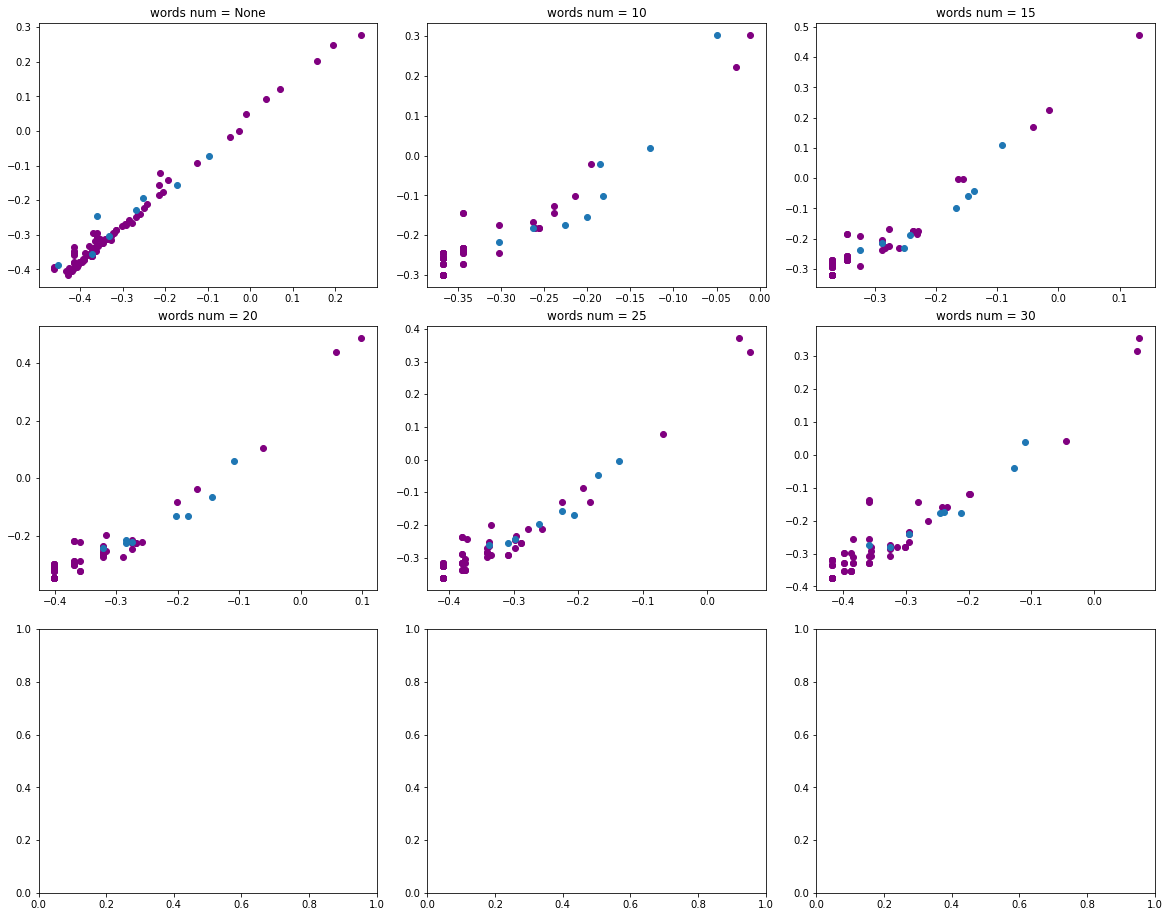

In [82]:
# Синие точки - документ соответствует группе
# Фиолетовые - выбросы

length = [None, 10, 15, 20, 25, 30]
graph_features(length, 'min_max', 1, 0.5)

Количество важных слов = None, количество доков в диапазоне до 0.5 = 92
Количество важных слов = 10, количество доков в диапазоне до 0.5 = 90
Количество важных слов = 15, количество доков в диапазоне до 0.5 = 91
Количество важных слов = 20, количество доков в диапазоне до 0.5 = 90
Количество важных слов = 25, количество доков в диапазоне до 0.5 = 89
Количество важных слов = 30, количество доков в диапазоне до 0.5 = 89


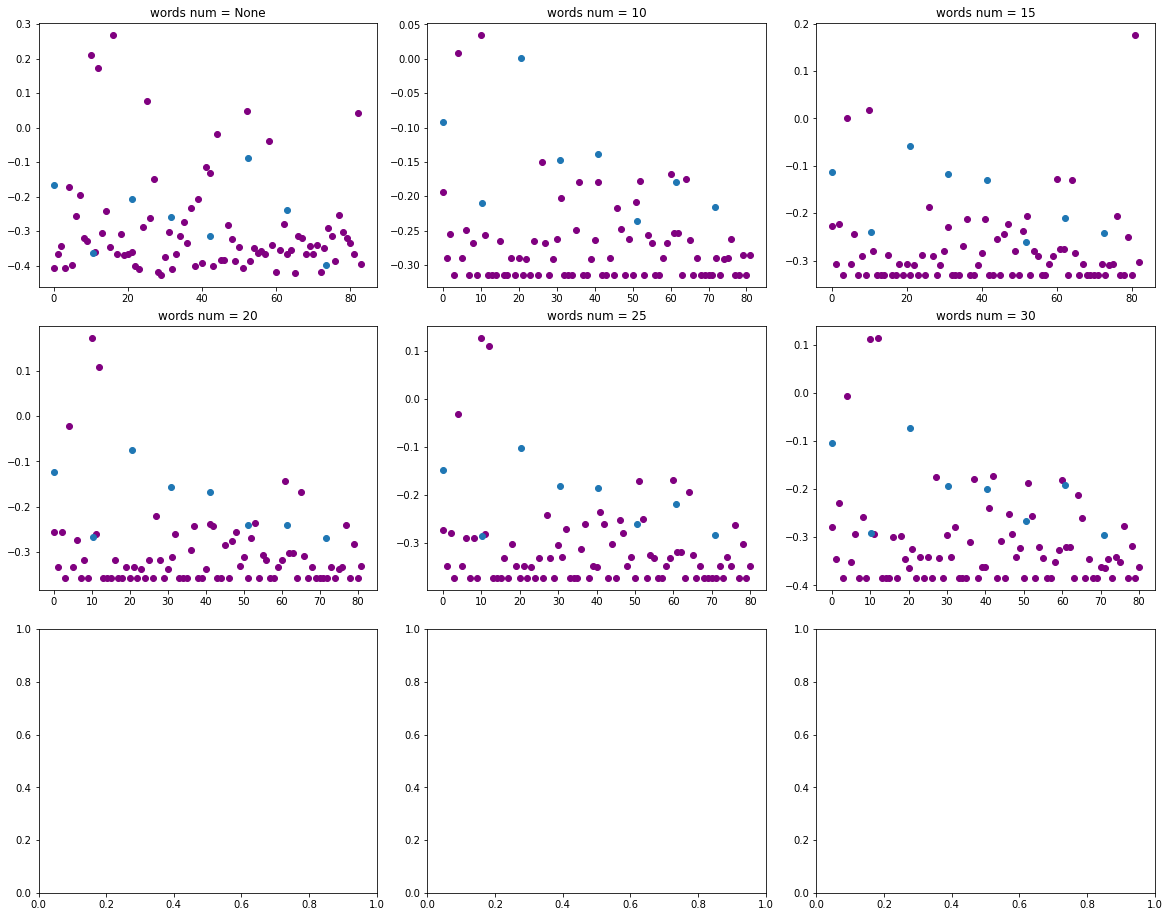

In [83]:
graph_features(length, 'mean', 1, 0.5)

Количество важных слов = None, количество доков в диапазоне до 0.5 = 82
Количество важных слов = 10, количество доков в диапазоне до 0.5 = 74
Количество важных слов = 15, количество доков в диапазоне до 0.5 = 76
Количество важных слов = 20, количество доков в диапазоне до 0.5 = 74
Количество важных слов = 25, количество доков в диапазоне до 0.5 = 72
Количество важных слов = 30, количество доков в диапазоне до 0.5 = 71


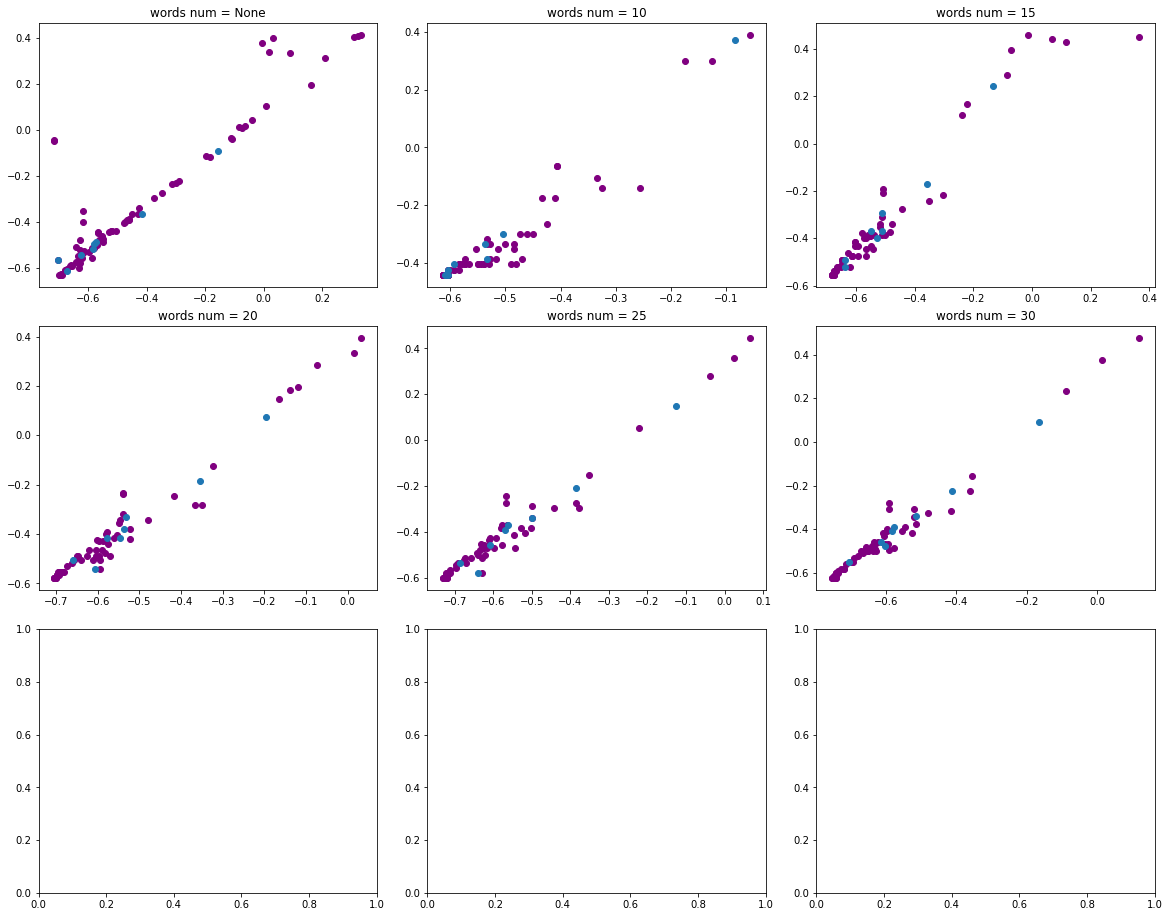

In [58]:
graph_features(length, 'min_max', 1, 0.5)

Количество важных слов = None, количество доков в диапазоне до 0.5 = 82
Количество важных слов = 10, количество доков в диапазоне до 0.5 = 74
Количество важных слов = 15, количество доков в диапазоне до 0.5 = 76
Количество важных слов = 20, количество доков в диапазоне до 0.5 = 74
Количество важных слов = 25, количество доков в диапазоне до 0.5 = 72
Количество важных слов = 30, количество доков в диапазоне до 0.5 = 71


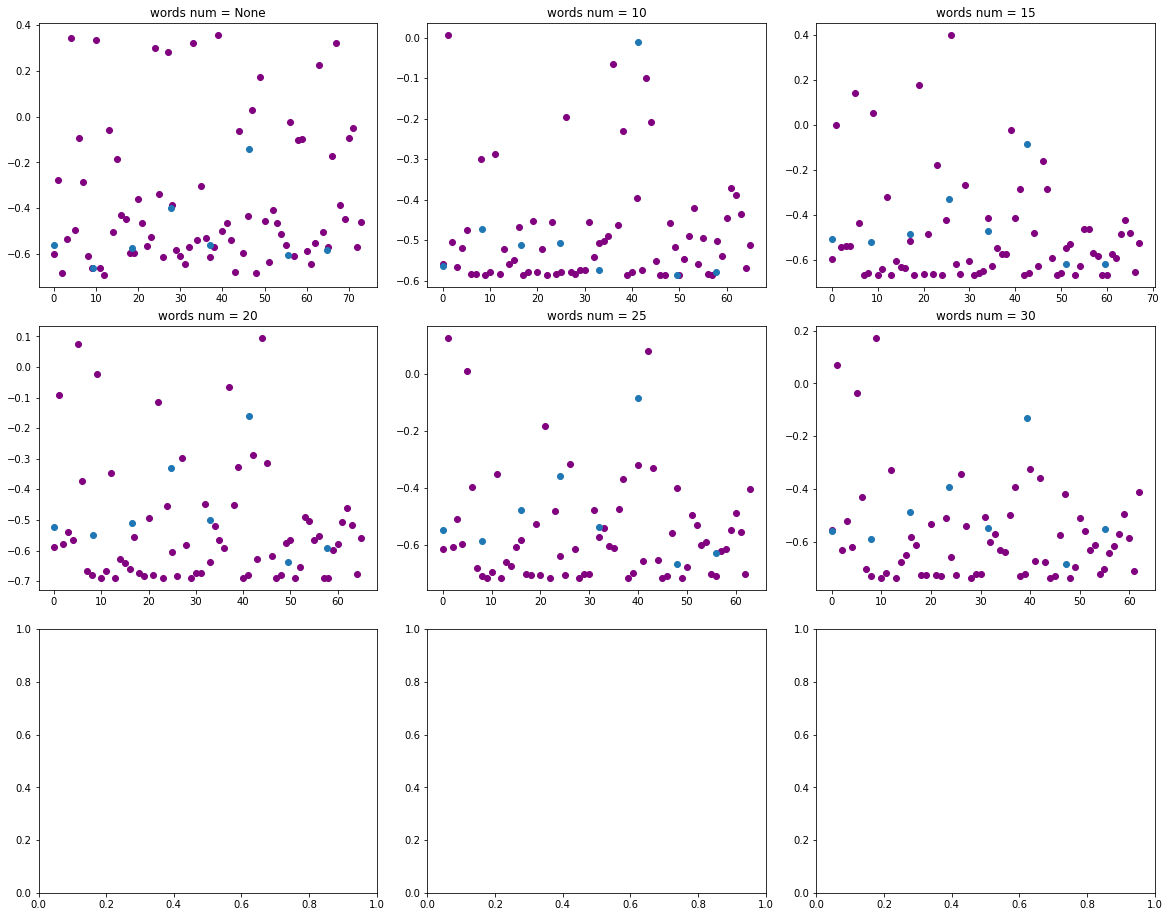

In [59]:
graph_features(length, 'mean', 1, 0.5)